### Full analysis of modes, overlap integrals, normalization factor for a waveguide with a single TE mode

Let's try a case that is almost single mode.

In [1]:
import lumerical as lum
import numpy as  np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import imp
import time
import os
from scipy.integrate import simps
import matplotlib.patches as patches
import matplotlib.cm as cm

from scipy.constants import pi, c, epsilon_0
pm = 1e-12
nm = 1e-9
um = 1e-6
mm = 1e-3
ps = 1e-12
fs = 1e-15
GHz = 1e9
THz = 1e12
pJ = 1e-12
mW = 1e-3

plt.rcParams.update({'font.size': 18})

In [2]:
data_filename = 'Data\LNoI_700nm_250nm_699nm.npz'
file = np.load(data_filename, allow_pickle=True)
locals().update(file)
freqs = c/wavelength
fstep = freqs[1] - freqs[0]

#Deep copies
neff_original = np.empty_like(neff)
neff_original[:] = neff
tepf_original = np.empty_like(tepf)
tepf_original[:] = tepf

In [3]:
print('Waveguide parameters')
print('thin-film thickness = %0.1f nm' % (h_LN/nm))
print('top witdh = %0.1f nm' % (width_top/nm))
print('etch depth = %0.1f nm' % (h_etch/nm))
print('etch angle = %0.1f degrees' % (theta))

Waveguide parameters
thin-film thickness = 700.0 nm
top witdh = 700.0 nm
etch depth = 250.0 nm
etch angle = 60.0 degrees


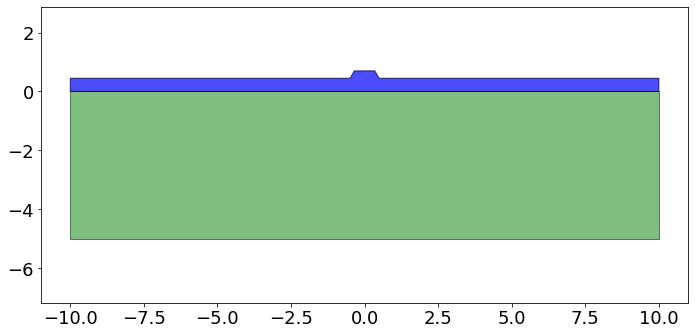

In [4]:
#Draw it
h_slab = h_LN - h_etch
width_top_base = width_top + 2*h_etch/np.tan(theta*pi/180)
w_sidewall = h_etch/np.tan(theta*pi/180)

plt.rcParams['figure.figsize'] = [10, 5]
fig,ax = plt.subplots()
substrate = patches.Rectangle((-w_slab/2/um,-h_substrate/um), w_slab/um, h_substrate/um,
                             linewidth=1, edgecolor='k', facecolor='g', alpha=0.5)
v_ridge = np.array([[-width_top/2-w_sidewall,h_slab], [-width_top/2,h_LN],
                   [width_top/2,h_LN], [width_top/2+w_sidewall,h_slab],
                   [w_slab/2,h_slab], [w_slab/2,0], 
                   [-w_slab/2,0], [-w_slab/2, h_slab] ] )/um
ridge = patches.Polygon(v_ridge, linewidth=1, 
                       edgecolor='k', facecolor='blue', alpha=0.7)

ax.add_patch(substrate)
ax.add_patch(ridge)

plt.axis('equal')
plt.tight_layout()
plt.show()

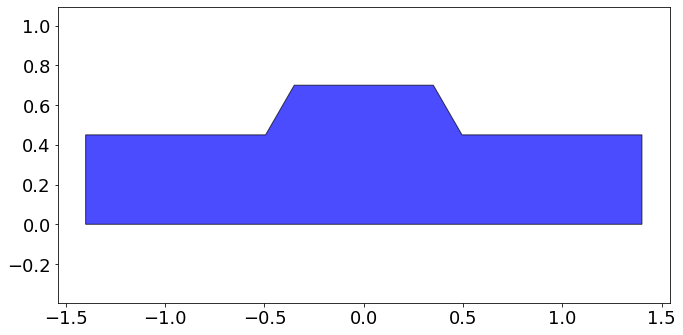

In [5]:
plt.rcParams['figure.figsize'] = [10, 5]
fig,ax = plt.subplots()

v_ridge = np.array([[-width_top/2-w_sidewall,h_slab], [-width_top/2,h_LN],
                   [width_top/2,h_LN], [width_top/2+w_sidewall,h_slab],
                   [2*width_top, h_slab], [2*width_top ,0], 
                   [-2*width_top, 0], [-2*width_top, h_slab] ] )/um
ridge = patches.Polygon(v_ridge, linewidth=1, 
                       edgecolor='k', facecolor='blue', alpha=0.7)

ax.add_patch(ridge)

plt.axis('equal')
plt.tight_layout()
plt.show()

## Let's see some of the data

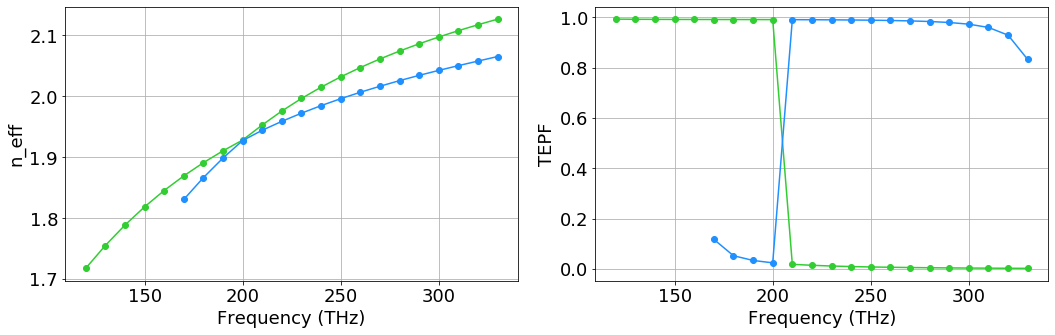

In [6]:
plt.rcParams['figure.figsize'] = [15, 5]

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_prop_cycle(color=['limegreen', 'dodgerblue'])
ax2.set_prop_cycle(color=['limegreen', 'dodgerblue'])
ax1.plot(freqs/THz, neff_original, marker='o');
ax2.plot(freqs/THz, tepf_original, marker='o');
ax1.grid(True); ax2.grid(True)
ax1.set_xlabel('Frequency (THz)')
ax2.set_xlabel('Frequency (THz)')
ax1.set_ylabel('n_eff')
ax2.set_ylabel('TEPF')
plt.tight_layout()

So, there's a mode crossing around 200 THz. Let's ignore this. Let's assume there's a single mode that is TE and covers over the whole band.

Let's choose that mode.

In [7]:
tepf[tepf != tepf] = 0 #get rid of nan
idx = tepf>0.8

tepf = tepf[idx]
neff = neff[idx]
ng = ng[idx]
modes = modes[idx]

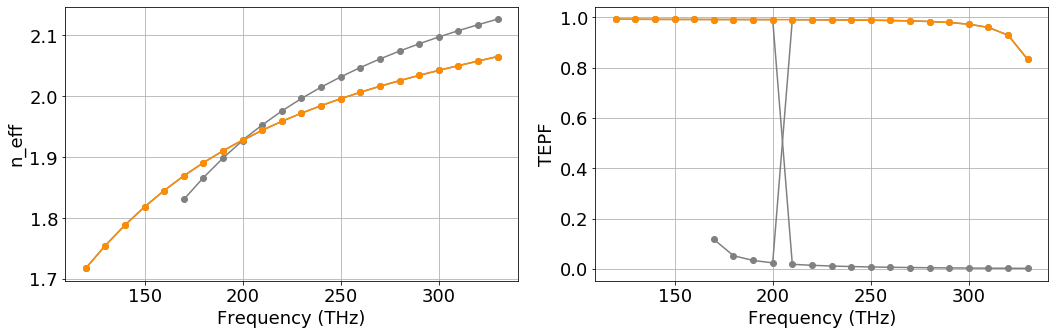

In [8]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(freqs/THz, neff_original,  marker='o', color='gray');
ax1.plot(freqs/THz, neff,  marker='o', color='darkorange');
ax2.plot(freqs/THz, tepf_original, marker='o', color='gray');
ax2.plot(freqs/THz, tepf, marker='o', color='darkorange');
ax1.grid(True); ax2.grid(True)
ax1.set_xlabel('Frequency (THz)')
ax2.set_xlabel('Frequency (THz)')
ax1.set_ylabel('n_eff')
ax2.set_ylabel('TEPF')
plt.tight_layout()

Let's look at the normalization constant from the modes.

Text(0, 0.5, '$N(\\omega)$')

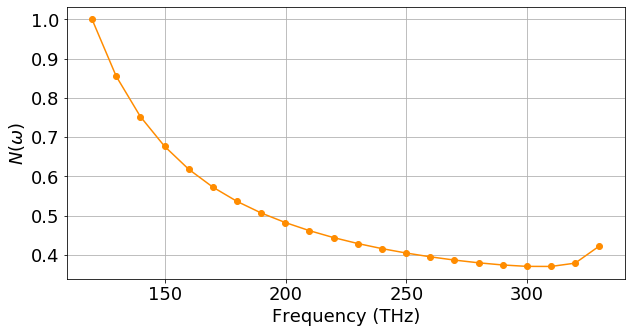

In [9]:
N = np.empty( neff.size )
for km in range(neff.size):
    N[km]  = modes[km].N()
    
plt.rcParams['figure.figsize'] = [10, 5]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(freqs/THz, N/np.amax(N),  marker='o', color='darkorange');
ax1.grid(True)
ax1.set_xlabel('Frequency (THz)')
ax1.set_ylabel('$N(\omega)$')

### We can also look at the modes themselves.

In [10]:
x = modes[1].E.xx
y = modes[1].E.yy
X, Y = np.meshgrid(x,y)

In [11]:
def plot_mode(F, ax):
    xlim = [-2,2]
    
    #Draw the mode
    ax.pcolormesh(X/um, Y/um, (np.transpose(F)), cmap=cm.jet)
    
    #Draw the waveguide
    v_ridge = np.array([[-width_top/2-w_sidewall,h_slab], [-width_top/2,h_LN],
                       [width_top/2,h_LN], [width_top/2+w_sidewall,h_slab],
                       [xlim[1], h_slab], [xlim[1], 0], 
                       [xlim[0], 0], [xlim[0], h_slab] ] )/um
    
    ridge = patches.Polygon(v_ridge, linewidth=1.5, edgecolor='k', alpha=1, fill=False)

    ax.add_patch(ridge)

    #Make Pretty
    ax.set_xlim(xlim)
    ax.set_ylim([-2, 2])
    ax.set_xlabel('X (microns)')
    ax.set_ylabel('Y (microns)')

In [12]:
def create_mask():
    mask = np.transpose(np.real(np.ones_like(modes[1].E.x)))
    mask[Y> (X+width_top/2+w_sidewall)*np.tan(theta*pi/180)+h_slab] = 0
    mask[Y> (-X+width_top/2+w_sidewall)*np.tan(theta*pi/180)+h_slab] = 0
    mask[Y < h_slab] = 1
    mask[Y>h_LN] = 0
    mask[Y<0] = 0
    return np.transpose(mask)

mask = create_mask()

In [13]:
idx_2um = 3
idx_1um = 8

print(freqs[idx_2um]/THz)
print(freqs[idx_1um]/THz)

149.9169832
199.9169832


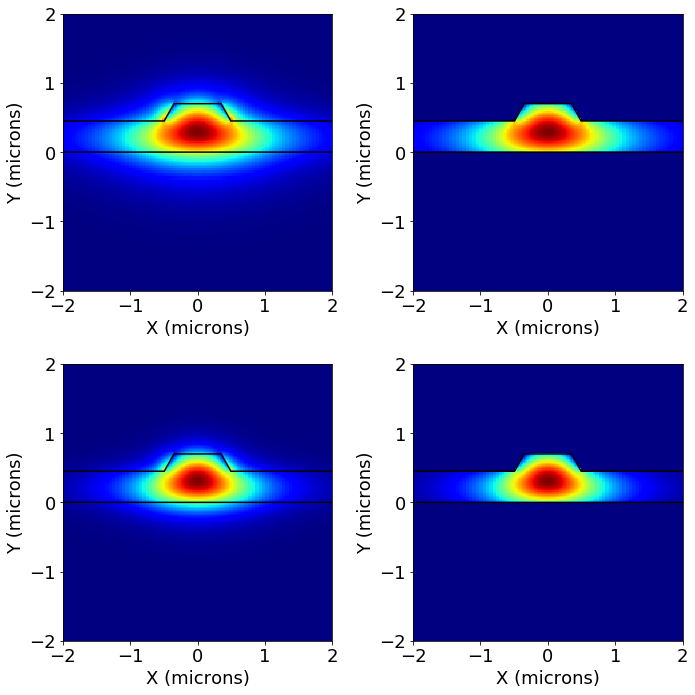

In [14]:
plt.rcParams['figure.figsize'] = [10, 10]

F1 = np.real(modes[idx_2um].E.x)
F2 = np.real(modes[idx_2um].E.x * mask)
F3 = np.real(modes[idx_1um].E.x)
F4 = np.real(modes[idx_1um].E.x * mask)

fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

plot_mode(F1, ax1)
plot_mode(F2, ax2)
plot_mode(F3, ax3)
plot_mode(F4, ax4)

plt.tight_layout()

## Nonlinear Polarization

Let's start with the nonlinear susceptibility tensor.

In [15]:
d31 = 3.67*pm
d22 = -1.78*pm
d33 = 20.5*pm

chi2 = np.zeros([3,3,3])
chi2[2,2,2] = d33
chi2[([0,0,1,1,2,2], [2,0,1,2,0,1], [0,2,2,1,0,1])] = d31
chi2[([1,1,0,0], [1,0,0,1], [1,0,1,0])] = d22
chi2/pm

array([[[ 0.  , -1.78,  3.67],
        [-1.78,  0.  ,  0.  ],
        [ 3.67,  0.  ,  0.  ]],

       [[-1.78,  0.  ,  0.  ],
        [ 0.  , -1.78,  3.67],
        [ 0.  ,  3.67,  0.  ]],

       [[ 3.67,  0.  ,  0.  ],
        [ 0.  ,  3.67,  0.  ],
        [ 0.  ,  0.  , 20.5 ]]])

We need to permute the axes of the fields to match the crystal labels, so x->z, y->x, z->y

In [16]:
def permute_axes(A):
    Bx = A.y
    By = A.z
    Bz = A.x
    return lum.field_2D(A.xx, A.yy, Bx, By, Bz)

In [17]:
def polarization(E1, E2):
    Px = np.zeros_like(E1.x)
    Py = np.zeros_like(E1.x)
    Pz = np.zeros_like(E1.x)
    
    Ea = np.array([E1.x, E1.y, E1.z])
    Eb = np.array([E2.x, E2.y, E2.z])
    
    for kj in range(3):
        for kz in range(3):
            Px = Px + chi2[0, kj, kz] * Ea[kj] * Eb[kz]
            Py = Py + chi2[1, kj, kz] * Ea[kj] * Eb[kz]
            Pz = Pz + chi2[2, kj, kz] * Ea[kj] * Eb[kz]
            
    Px = epsilon_0 * Px * mask
    Py = epsilon_0 * Py * mask
    Pz = epsilon_0 * Pz * mask
    
    P = lum.field_2D(E1.xx, E1.yy, Px, Py, Pz)
    return P

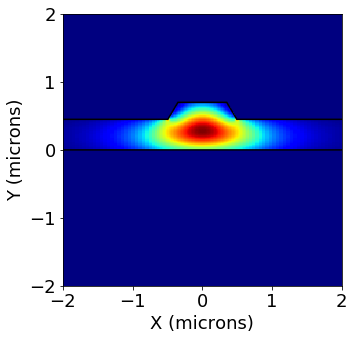

In [18]:
E1 = permute_axes(modes[1].E)
E2 = permute_axes(modes[1].E)
P = polarization(E1, E2)
F = np.abs(P.z)

plt.rcParams['figure.figsize'] = [5, 5]
fig = plt.figure()
ax1 = fig.add_subplot(111)
plot_mode(F, ax1)

## Overlap Integral

In [19]:
def X_func(Ea, Eb, Ec):
    '''
    Input fields are in Lumerical coordinate frame (not crystal frame)
    '''
    
    #Need to map lumerical coordinate system to crystal axes
    E1 = permute_axes(Ea)
    E2 = permute_axes(Eb)
    E3 = permute_axes(Ec)
    
    P = polarization(E2,E3)
    integrand = P.dot(E1.conj())
    
    return simps(simps(integrand, P.yy), P.xx)

In [20]:
def get_X_array(Nnew):
    '''This gets the 2D X array given a normalization vector N vs frequency'''
    X_array = 1j * np.zeros([freqs.size, freqs.size])
    for k1 in range(wavelength.size):
        for k2 in range(wavelength.size):
            f1 = freqs[k1]
            f2 = freqs[k2]

            k3 = np.argwhere(np.isclose(freqs, np.abs(f1 - f2), atol=fstep/10))
            if k3.size != 0:
                k3 = k3[0, 0]
                f3 = freqs[k3]

                E1 = modes[k1].E
                E2 = modes[k2].E
                E3 = modes[k3].E

                s1 = np.sqrt(Nnew[k1] / N[k1])
                s2 = np.sqrt(Nnew[k2] / N[k2])
                s3 = np.sqrt(Nnew[k3] / N[k3])

                E1 = E1.rescale(s1)
                E2 = E2.rescale(s2)
                E3 = E3.rescale(s3)

                if f3<0:
                    E3 = E3.conj()

                X_array[k1, k2] = X_func(E1, E2, E3)

    X_array[X_array == 0] = np.nan
    return X_array

In [21]:
def ratio(X_array):
    r = np.nanmax(np.abs(X_array))/np.nanmin(np.abs(X_array))
    print(r)
    return r

Let's try a linear variation in N

In [22]:
# # Sweep for optimization
# n_stop = np.arange(1.1, 2.5, 0.1)
# ratio_sweep = np.zeros_like(n_stop)

# for kn in range(n_stop.size):
#     Ntest = (N/np.amax(N)) / np.linspace(n_stop[kn], 1, num=freqs.size)
#     ratio_sweep[kn] = ratio(get_X_array(Ntest))

Text(0, 0.5, '$N(\\omega)$')

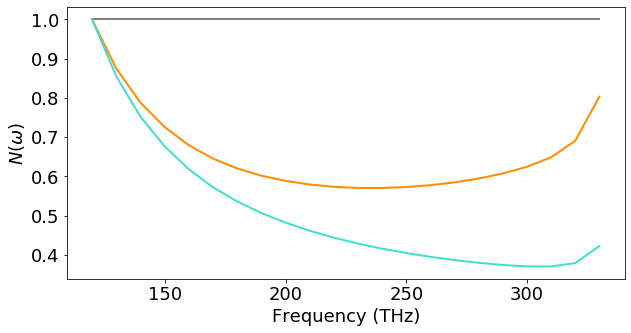

In [23]:
N1 = np.ones_like(freqs)
N_opt = (N/np.amax(N)) / np.linspace(1.9, 1, num=freqs.size)

plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(freqs/THz, N_opt/np.amax(N_opt), color='darkorange', linewidth=2)
plt.plot(freqs/THz, N1, color='grey', linewidth=2)
plt.plot(freqs/THz, N/np.amax(N), color='turquoise', linewidth=2)
plt.xlabel('Frequency (THz)')
plt.ylabel('$N(\omega)$')
# plt.grid(True)

In [24]:
X_array_lumerical = get_X_array(N/np.amax(N))
X_array_normalized = get_X_array(N1)
X_array_opt = get_X_array(N_opt)

In [25]:
ratio(X_array_lumerical);
ratio(X_array_normalized);
ratio(X_array_opt);

1.3328222811487762
1.2962407759501595
1.05892000741994


Text(0, 0.5, '$\\omega^\\prime/2\\pi$ (THz)')

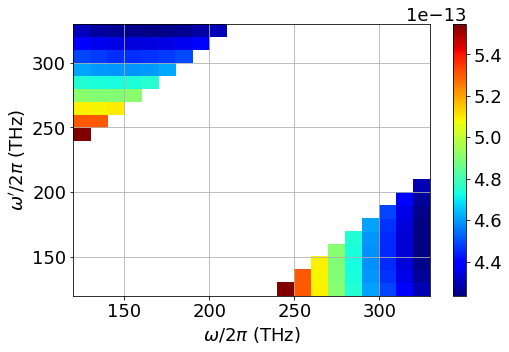

In [26]:
F1, F2 = np.meshgrid(freqs/THz, freqs/THz)

plt.rcParams['figure.figsize'] = [8, 5]
plt.figure()
plt.pcolormesh(F1, F2, (np.transpose(np.abs(X_array_lumerical))), cmap=cm.jet)
plt.colorbar()
plt.grid(True)
plt.xlabel('$\omega/2\pi $ (THz)')
plt.ylabel('$\omega^\prime/2\pi$ (THz)')

Text(0, 0.5, '$\\omega^\\prime/2\\pi$ (THz)')

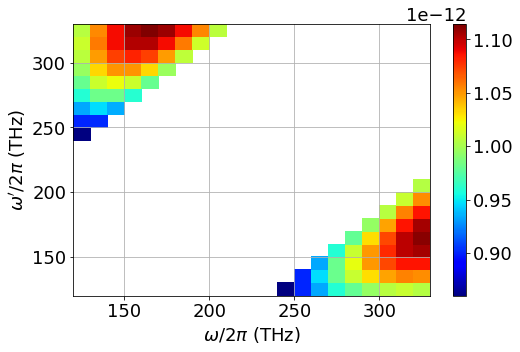

In [27]:
plt.figure()
plt.pcolormesh(F1, F2, (np.transpose(np.abs(X_array_normalized))), cmap=cm.jet)
plt.colorbar()
plt.grid(True)
plt.xlabel('$\omega/2\pi $ (THz)')
plt.ylabel('$\omega^\prime/2\pi$ (THz)')

Text(0, 0.5, '$\\omega^\\prime/2\\pi$ (THz)')

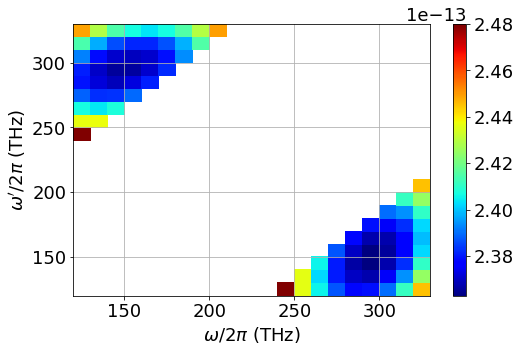

In [28]:
plt.figure()
plt.pcolormesh(F1, F2, (np.transpose(np.abs(X_array_opt))), cmap=cm.jet)
plt.colorbar()
plt.grid(True)
plt.xlabel('$\omega/2\pi $ (THz)')
plt.ylabel('$\omega^\prime/2\pi$ (THz)')